In [13]:
import time

from metrics import *
from RedistrictingMarkovChain import RedistrictingMarkovChain

from gerrychain import Graph
import matplotlib.pyplot as plt

In [2]:
STEPS = [1000, 5000, 10000, 20000, 50000]

In [3]:
start_time = time.time()
print("Starting graph load")
ny_graph = Graph.from_file("./NY-lab/NY.shp")
print("Graph loaded")
end_time = time.time()

print(f"Graph load time: {(end_time - start_time) / 60} minutes")

Starting graph load


/Users/travisoleson/anaconda3/envs/ei/lib/python3.11/site-packages/gerrychain/graph/graph.py:388: UserWarning: Found islands (degree-0 nodes). Indices of islands: {134451, 134452}
  warnings.warn(
/Users/travisoleson/anaconda3/envs/ei/lib/python3.11/site-packages/gerrychain/graph/graph.py:262: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


Graph loaded
Graph load time: 8.945842031637827 minutes


In [4]:
election = {"name": "G20PRE", "dem": "G20PRED", "rep": "G20PRER"}
pop_tol = 0.03

In [5]:
ny_markov_chain = RedistrictingMarkovChain(ny_graph,
                                                   26,
                                                   "CD",
                                                   election["name"],
                                                   election["dem"],
                                                   election["rep"],
                                                   "TOTPOP",
                                                   "HISP",
                                                   "BVAP",  # TODO
                                                   pop_tolerance=pop_tol)

In [6]:
#ny_markov_chain.init_partition()

In [7]:
# def calc_metrics(initial_partition):
    
#     part_mmd = mm(initial_partition, "G20PRE", "Democratic")
#     part_eg = eg(initial_partition, "G20PRE")
#     part_pb = pb(initial_partition, "G20PRE")

#     return part_mmd, part_eg, part_pb

In [8]:
# part_mmd, part_eg, part_pb = calc_metrics(initial_part)

In [16]:
def plot_histograms_nb(ensemble, filename, title, xlabel=None, ylabel=None):
    plt.figure()
    plt.title(f"{title} Histogram")
    # plt.axvline(x=5, color="red", linestyle="--", linewidth=2, alpha=0.7)  # TODO add dynamic x
    if xlabel is not None and ylabel is not None:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.hist(ensemble, align="mid")  # left
    plt.savefig(filename)

### Proof of Concept

In [10]:
elec_name = election.get("name")

In [11]:
ny_init_state = ny_markov_chain.init_markov_chain(steps=200)

Walking the ensemble
Walk complete
Markov Chain time (steps=200): 0.0732306162516276 minutes


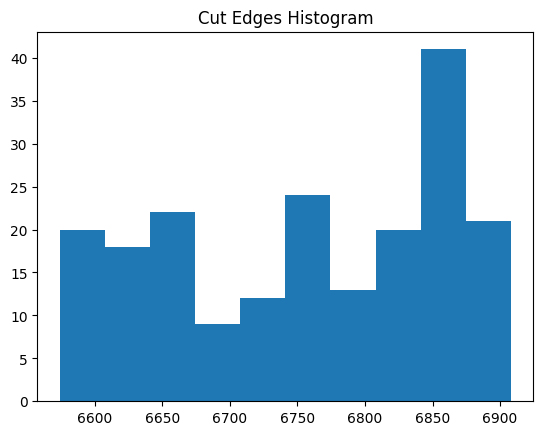

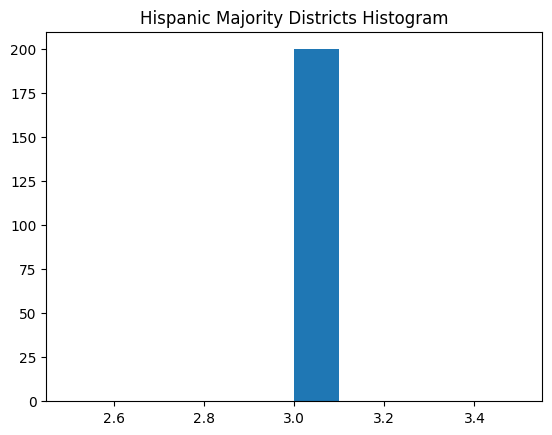

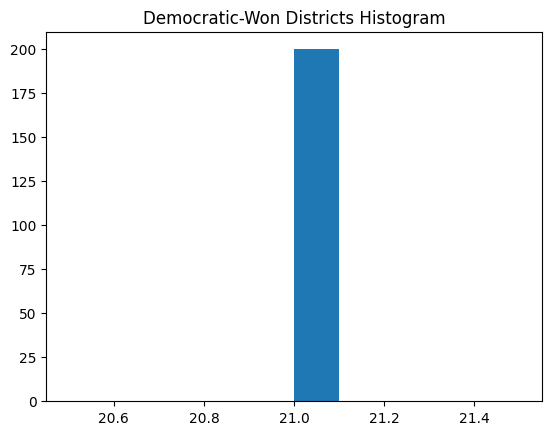

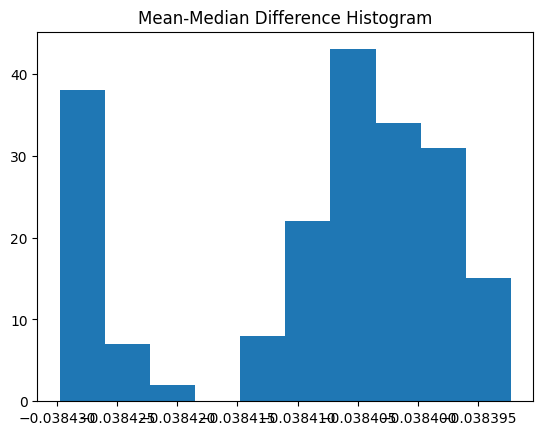

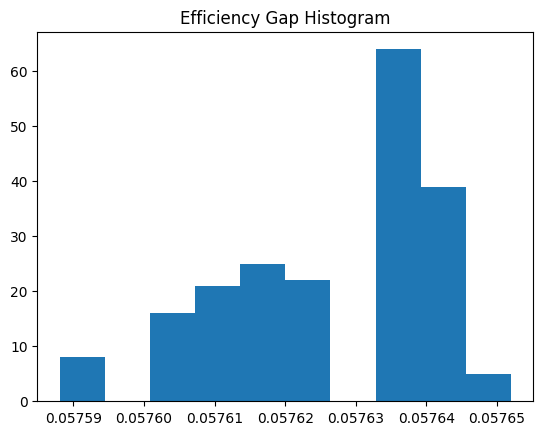

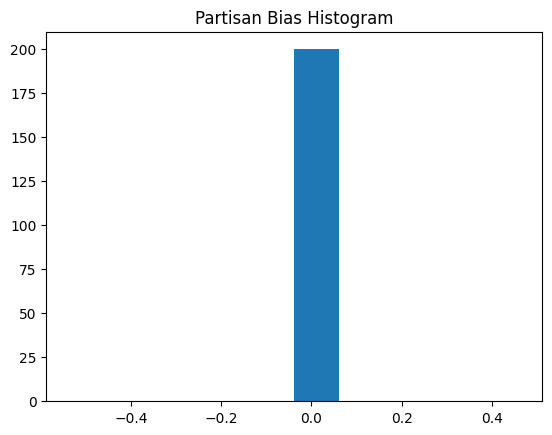

In [17]:
start_time = time.time()

cutedge_ensemble, lmaj_ensemble, dem_win_ensemble, mmd_ensemble, eg_ensemble, pb_ensemble = ny_markov_chain.walk_the_run()

# Save test histograms
# 1. Cut edge
plot_histograms_nb(cutedge_ensemble,
                f"histograms/test_cutedge_ensemble_200_{pop_tol}_{elec_name}.png",
                "Cut Edges",
               )
# 2. Majority-Latino districts
plot_histograms_nb(lmaj_ensemble,
                f"histograms/test_lmaj_ensemble_200_{pop_tol}_{elec_name}.png",
                "Hispanic Majority Districts",
               )
# 3. Democratic-won districts
plot_histograms_nb(dem_win_ensemble,
                f"histograms/test_dem_win_ensemble_200_{pop_tol}_{elec_name}.png",
                "Democratic-Won Districts",
               )
# 4. Mean-Median Difference
plot_histograms_nb(mmd_ensemble,
                f"histograms/test_mmd_ensemble_200_{pop_tol}_{elec_name}.png",
                "Mean-Median Difference",
               )
# 5. Efficiency Gap
plot_histograms_nb(eg_ensemble,
                f"histograms/test_eg_ensemble_200_{pop_tol}_{elec_name}.png",
                "Efficiency Gap",
               )
# 6. Partisan Bias
plot_histograms_nb(pb_ensemble,
                f"histograms/test_pb_ensemble_200_{pop_tol}_{elec_name}.png",
                "Partisan Bias",
               )

end_time = time.time()
print(f"Markov Chain time (steps=200): {(end_time - start_time) / 60} minutes")

In [18]:
# for step in STEPS:
#     start_time = time.time()
#     ny_markov_chain.init_markov_chain(steps=step)
#     cutedge_ensemble, lmaj_ensemble, dem_win_ensemble, mmd_ensemble, eg_ensemble, pb_ensemble  = ny_markov_chain.walk_the_run()

#     elec_name = election.get("name")
#     # Histograms
#     # 1. Cut edge
#     plot_histograms_nb(cutedge_ensemble,
#                     f"histograms/propose_random_flip_cutedge_ensemble_{step}_{pop_tol}_{elec_name}.png",
#                     "Cut Edges",
#                    )
#     # 2. Majority-Latino districts
#     plot_histograms_nb(lmaj_ensemble,
#                     f"histograms/propose_random_flip_lmaj_ensemble_{step}_{pop_tol}_{elec_name}.png",
#                     "Hispanic Majority Districts",
#                    )
#     # 3. Democratic-won districts
#     plot_histograms_nb(dem_win_ensemble,
#                     f"histograms/propose_random_flip_dem_win_ensemble_{step}_{pop_tol}_{elec_name}.png",
#                     "Democratic-Won Districts",
#                    )

#     # 4. Mean-Median Difference
#     plot_histograms_nb(mmd_ensemble,
#                     f"histograms/propose_random_flip_mmd_ensemble_{step}_{pop_tol}_{elec_name}.png",
#                     "Mean-Median Difference",
#                    )

#     # 5. Efficiency Gap
#     plot_histograms_nb(eg_ensemble,
#                     f"histograms/propose_random_flip_eg_ensemble_{step}_{pop_tol}_{elec_name}.png",
#                     "Efficiency Gap",
#                    )

#     # 6. Partisan Bias
#     plot_histograms_nb(pb_ensemble,
#                     f"histograms/propose_random_flip_pb_ensemble_{step}_{pop_tol}_{elec_name}.png",
#                     "Partisan Bias",
#                    )
#     end_time = time.time()

#     print(f"Markov Chain time (steps={step}): {(end_time - start_time) / 60} minutes")